# Decode stimuli from neural activity - across multiple sessions

In [5]:
#Import packages
import pandas as pd
import h5py
import numpy as np
import scipy as sp
import scipy.signal as sg
import xarray as xr
import os
import matplotlib.pyplot as plt
from matplotlib import patches
import ast
from sklearn import svm
import time

from DR_analysis_utils import Session, makePSTH, make_neuron_time_trials_tensor

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report

%matplotlib notebook

In [18]:
#Set paths to experiment folders
main_path = [
    r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-07-26_14-09-36_620263\processed",
    r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-07-27_13-57-17_620263\processed",
    r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-08-02_15-40-19_620264\processed",
    r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-09-19_13-48-26_628801\processed",
    r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-09-26_12-48-09_636397\processed",
    r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-09-27_11-37-08_636397\processed",
    r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-12-05_13-08-02_644547\processed",
    r"\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-12-06_12-35-35_644547\processed",
]
modality = ['vis','vis','aud','vis','aud','aud','vis','vis']

## Loop through sessions

In [16]:
start_time=time.time()

svc_results={}

for sel_session, path in enumerate(main_path):
    svc_results[sel_session]={}
    svc_results[sel_session]['modality']=modality[sel_session]
    svc_results[sel_session]['results']={}
    
    print(path+' ... processing')
    session=Session(path=path) 

    # loop through sessions and make unit xarrays
    time_before_flash = 1.5
    trial_duration = 3
    bin_size = 0.001


    # Make tensor (3-D matrix [units,time,trials])
    trial_tensor = make_neuron_time_trials_tensor(session.good_units, session.spike_times, 
                                                  session.trials,time_before_flash, trial_duration, 
                                                  bin_size)

    # make xarray
    session.trial_da = xr.DataArray(trial_tensor, dims=("unit_id", "time", "trials"), 
                               coords={
                                   "unit_id": session.good_units.index.values,
                                   "time": np.arange(0, trial_duration, bin_size)-time_before_flash,
                                   "trials": session.trials.index.values
                                   })
    
    #exclude catch trials for now
    trial_sel=session.trials.query('trialStimID != "catch"').index
    
    # grab the stimulus ids
    stim_ids = np.vstack(session.trials['trialStimID'][trial_sel].values)
    
    probes=session.good_units['probe'].unique()
    
    #loop through units on each probe
    for pr in probes:
        svc_results[sel_session]['results'][pr]={}
        
        unit_sel=session.good_units.query('probe == @pr').index
        
        #grab different time windows
        time_wins={}
        #1: -250:0ms
        time_wins['prestim'] = session.trial_da.sel(time=slice(-1.5,-1.25),trials=trial_sel,
                                                    unit_id=unit_sel).mean(dim='time').values
        #2: 0:250ms
        time_wins['stim_initial'] = session.trial_da.sel(time=slice(0,0.25),trials=trial_sel,
                                                         unit_id=unit_sel).mean(dim='time').values
        #3: 250:500ms
        time_wins['stim_steady'] = session.trial_da.sel(time=slice(0.25,0.5),trials=trial_sel,
                                                        unit_id=unit_sel).mean(dim='time').values
        
        #loop through different time windows
        for tw in time_wins.keys():
            X = time_wins[tw].T
            y = stim_ids
            
            #future: do manual 5-fold cross-validation
            xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.5)
            
            clf = svm.LinearSVC()
            clf.fit(xtrain, ytrain)
            
            ypred = clf.predict(xtest)
            
            cr_dict=classification_report(ytest, ypred, output_dict=True)
            cr_df=pd.DataFrame.from_dict(cr_dict)
            
            svc_results[sel_session]['results'][pr][tw]=cr_df
    
    elapsed_t=time.time()-start_time
    print(' ... done '+str(np.round(elapsed_t))+' sec')

\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-07-26_14-09-36_620263\processed ... processing


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: Da

 ... done 78.0 sec
\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-07-27_13-57-17_620263\processed ... processing


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: Da

 ... done 142.0 sec
\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-08-02_15-40-19_620264\processed ... processing


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `ze

 ... done 218.0 sec
\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-09-19_13-48-26_628801\processed ... processing


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=

 ... done 303.0 sec
\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-09-26_12-48-09_636397\processed ... processing


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: Da

 ... done 371.0 sec
\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-09-27_11-37-08_636397\processed ... processing


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: Da

 ... done 433.0 sec
\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-12-05_13-08-02_644547\processed ... processing


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: Da

 ... done 554.0 sec
\\allen\programs\mindscope\workgroups\templeton\TTOC\pilot recordings\2022-12-06_12-35-35_644547\processed ... processing


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\utils\validation.py:1111: Da

 ... done 635.0 sec


C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [17]:
svc_results

{0: {'modality': 'vis',
  'results': {'B': {'prestim':               sound1     sound2       vis1       vis2  accuracy   macro avg  \
    precision   0.287356   0.243902   0.178082   0.227273  0.237013    0.234153   
    recall      0.308642   0.253165   0.185714   0.192308  0.237013    0.234957   
    f1-score    0.297619   0.248447   0.181818   0.208333  0.237013    0.234054   
    support    81.000000  79.000000  70.000000  78.000000  0.237013  308.000000   
    
               weighted avg  
    precision      0.236160  
    recall         0.237013  
    f1-score       0.236077  
    support      308.000000  ,
    'stim_initial':               sound1     sound2       vis1       vis2  accuracy   macro avg  \
    precision   0.456522   0.444444   0.987342   1.000000  0.720779    0.722077   
    recall      0.538462   0.363636   1.000000   0.986667  0.720779    0.722191   
    f1-score    0.494118   0.400000   0.993631   0.993289  0.720779    0.720259   
    support    78.000000  77.0

In [21]:
svc_results[0]['results']['B']['stim_initial']

,sound1,sound2,vis1,vis2,accuracy,macro avg,weighted avg
precision,0.456522,0.444444,0.987342,1.000000,0.720779,0.722077,0.720271
recall,0.538462,0.363636,1.000000,0.986667,0.720779,0.722191,0.720779
f1-score,0.494118,0.400000,0.993631,0.993289,0.720779,0.720259,0.718640
support,78.000000,77.000000,78.000000,75.000000,0.720779,308.000000,308.000000


In [27]:
svc_results[0]['results'].keys()

dict_keys(['B', 'C', 'F'])

0

In [104]:
# make into more plottable format

plot_results={}

timepoints=['prestim','stim_initial','stim_steady']

for tt in timepoints:
    plot_results[tt]={}
#     plot_results[tt]['modality']=modality
    for pr in svc_results[ss]['results'].keys():
        plot_results[tt][pr+'_vis']=[]
        plot_results[tt][pr+'_aud']=[]

probes=['A','B','C','F']
            
# diff table for each timepoint?
# row = session
# columns = ['modality','A_vis','A_aud','B_vis','B_aud','C_vis','C_aud','F_vis','F_aud',]
for tt in timepoints:
    for ss in range(0,len(svc_results)):
        
        for pr in probes: #svc_results[ss]['results'].keys():
            if pr in svc_results[ss]['results'].keys():
                vis_perf=(
                    np.sum([svc_results[ss]['results'][pr][tt]['vis1'][['precision','recall']].values,
                            svc_results[ss]['results'][pr][tt]['vis2'][['precision','recall']].values]))/4

                aud_perf=(
                    np.sum([svc_results[ss]['results'][pr][tt]['sound1'][['precision','recall']].values,
                            svc_results[ss]['results'][pr][tt]['sound2'][['precision','recall']].values]))/4


                plot_results[tt][pr+'_vis'].append(vis_perf)
                plot_results[tt][pr+'_aud'].append(aud_perf)
            
            else:
                plot_results[tt][pr+'_vis'].append(np.nan)
                plot_results[tt][pr+'_aud'].append(np.nan)

    plot_results[tt]=pd.DataFrame.from_dict(plot_results[tt])

In [105]:
plot_results['stim_initial']

,A_vis,A_aud,B_vis,B_aud,C_vis,C_aud,F_vis,F_aud
0,NaN,NaN,0.993502,0.450766,1.000000,1.000000,0.996622,0.667248
1,0.777017,0.599370,0.971696,0.646048,0.985830,0.902056,0.955493,0.490549
2,0.480891,0.857885,0.986928,0.820684,0.687041,0.984104,0.536427,0.871708
3,0.871498,0.546829,1.000000,0.988049,0.829000,1.000000,0.921751,0.592347
4,0.786719,0.829299,0.805973,0.884091,0.476715,0.842932,0.505199,0.818378
5,0.697338,0.780909,0.480825,0.432073,0.573191,0.976818,0.742750,0.944251
6,0.953726,0.613315,0.964978,0.489126,1.000000,0.835553,0.915078,0.413312
7,0.925882,0.553232,0.983289,0.445038,1.000000,0.959341,0.900412,0.442821


<IPython.core.display.Javascript object>


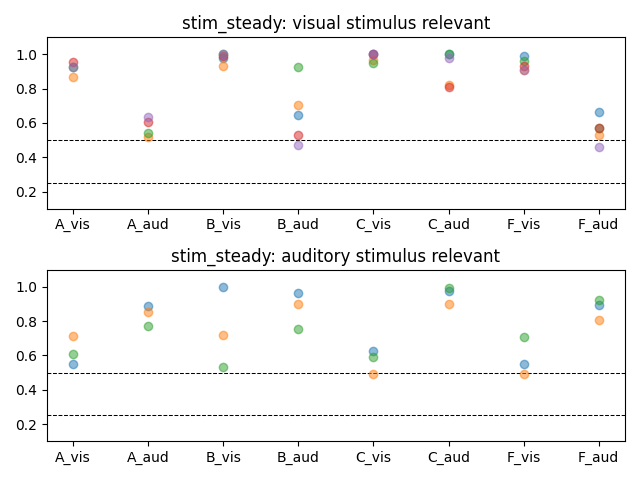

In [106]:
set_timepoint='stim_steady'

fig,ax=plt.subplots(2,1)
ax[0].axhline(0.25,color='k',linewidth=0.75,linestyle='--')
ax[0].axhline(0.5,color='k',linewidth=0.75,linestyle='--')
ax[0].plot(plot_results[set_timepoint][np.asarray(modality[:])=='vis'].values.T,'o',alpha=0.5)
ax[0].set_xticks(np.arange(0,8))
ax[0].set_xticklabels(plot_results[set_timepoint].columns)
ax[0].set_title(set_timepoint+': visual stimulus relevant')
ax[0].set_ylim([0.1,1.1])

ax[1].axhline(0.25,color='k',linewidth=0.75,linestyle='--')
ax[1].axhline(0.5,color='k',linewidth=0.75,linestyle='--')
ax[1].plot(plot_results[set_timepoint][np.asarray(modality[:])=='aud'].values.T,'o',alpha=0.5)
ax[1].set_xticks(np.arange(0,8))
ax[1].set_xticklabels(plot_results[set_timepoint].columns)
ax[1].set_title(set_timepoint+': auditory stimulus relevant')
ax[1].set_ylim([0.1,1.1])

fig.tight_layout()

In [69]:
plot_results['stim_initial'][np.asarray(modality) == 'vis']

,A_vis,A_aud,B_vis,B_aud,C_vis,C_aud,F_vis,F_aud
0,NaN,NaN,0.993502,0.450766,1.00000,1.000000,0.996622,0.667248
1,0.777017,0.599370,0.971696,0.646048,0.98583,0.902056,0.955493,0.490549
3,0.871498,0.546829,1.000000,0.988049,0.82900,1.000000,0.921751,0.592347
6,0.953726,0.613315,0.964978,0.489126,1.00000,0.835553,0.915078,0.413312
7,0.925882,0.553232,0.983289,0.445038,1.00000,0.959341,0.900412,0.442821
